### Student Information
Name: Shubhranshi Kapoor

Student ID: 109164422

GitHub ID: shubhranshi

Kaggle name: shubhranshikapoor (Shubhranshi Kapoor)

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)

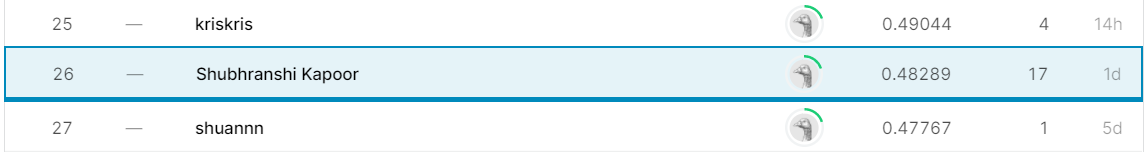

---

# Kaggle Competition : Emotion Recognition on Twitter

In this competition, we are provided a dataset which was crawled from Twitter, and we have already labeled the emotion for these tweets by some specific hashtags in the original text. There are 8 classes (or say emotions) in our dataset: anger, anticipation, disgust, fear, sadness, surprise, trust, and joy.

We have to clean the data by doing some pre-processing. Then, apply feature engineering or any other data mining technique. The final goal is to learn a model that is able to predict the emotion behind each tweet.

## Table of Content
1. Data
   1. Data Description
   2. Loading Data Set
   3. Data Exploration


2. Data Preprocessing
   1. Data Cleaning and Preprocessing


3. Feature Engineering
   1. Tokenize texts word_tokenize + TFIDF Vectorizer
   2. TweetTokenizer + TFIDF Vectorizer
   3. TweetTokenizer + tensorflow.keras Tokenizer


4. Train Model 
   1. Naive Bayes Model
   2. Logistic Regression Model
   3. LSTM Neural Network Model


5. Result Evaluation


6. Conclusion
   

## 1. Data

### 1.1 Data Description

1. tweets_DM.json - Raw data from Twitter
2. emotion.csv - Lists the emotion labels per tweet_id
3. data_identification.csv - A file that identifies membership of training or testing set per tweet_id. Note that you won´t be provided with the labels for the testing set, but you will have to predict for these when you make your submission.
4. sampleSubmission.csv - A submission format you should follow for submitting to the competition

### 1.2 Loading Data Set

Loading necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
from pandas import json_normalize

In [2]:
# reading data files

identity=pd.read_csv("data_identification.csv")
emotion=pd.read_csv("emotion.csv")
raw_data=pd.read_json("tweets_DM.json",lines=True)

# _source contains the tweet text
tweets=json_normalize(raw_data['_source'])

### 1.3 Data Exploration

#### 1. identity dataset

In [3]:
identity.shape

(1867535, 2)

In [4]:
identity.head()

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train


#### 2. emotion dataset 

In [5]:
emotion.shape

(1455563, 2)

In [6]:
emotion.head()

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation


#### 3. tweets dataset

In [7]:
tweets.shape

(1867535, 3)

In [8]:
tweets.head()

,tweet.hashtags,tweet.tweet_id,tweet.text
0,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,[],0x2de201,"""Trust is not the same as faith. A friend is s..."


## 2. Data Cleaning and Preprocessing

#### Getting data ready for use :

In [9]:
# rename column names
tweets = tweets.rename(index=str,
                       columns={"tweet.text":"text", "tweet.tweet_id":"tweet_id",
                                "tweet.hashtags":"hashtags"})

In [10]:
# add identify tags to dataframe
tweets = pd.merge(tweets,identity, on="tweet_id")

In [11]:
#get training set and test set
train_df = tweets[tweets["identification"] == "train"]
test_df = tweets[tweets["identification"] == "test"]

In [12]:
#add emotion column
train_df = pd.merge(train_df,emotion, on="tweet_id")
test_df = test_df.reindex(columns = test_df.columns.tolist() + ['emotion'])

In [13]:
#drop identification tags
train_df.drop(columns=["identification"],inplace=True)
test_df.drop(columns=["identification"],inplace=True)

In [14]:
#use tweet_id as index
train_df.set_index("tweet_id",inplace=True)
test_df.set_index("tweet_id",inplace=True)

#### Save Data :

In [15]:
## save to pickle file
train_df.to_pickle("train_df1.pkl") 
test_df.to_pickle("test_df1.pkl")

## load a pickle file
train_df = pd.read_pickle("train_df1.pkl")
test_df = pd.read_pickle("test_df1.pkl")

#### Data Distribution :

In [16]:
#group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

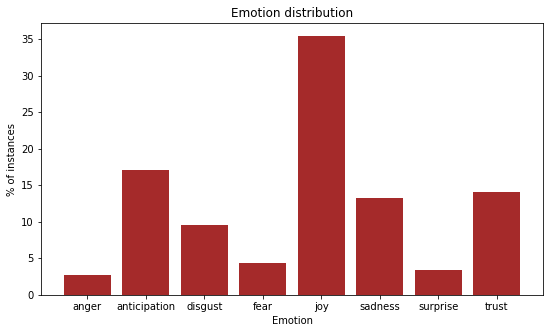

In [17]:
# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(9,5))
plt.bar(df1.index,df1.values,color='brown')

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.show()

#### Clean Text :

With the help of NLTK WordNetLemmatizer and stopwords, try to clean the tweet data in order to reduce the text length and get more meaningful words

In [18]:
import nltk
import re
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

In [19]:
stop_words = set(stopwords.words('english'))

In [20]:
def clean_text(tweet):
    
    lem = WordNetLemmatizer()                       #lemmatizer to change words to the dictionary root word
    
    tweet = re.sub("@[\w\d]+", "", tweet)           #delete any references to other people
    tweet = tweet.lower()
    
    tokens = nltk.tokenize.word_tokenize(tweet)     #word tokenizer
    tokens = [lem.lemmatize(token) for token in tokens if not token in stop_words]
    
    tokens = [token if len(token)>1 else token.replace(token,"") for token in tokens ]
    tokens = ' '.join(tokens)
    
    return tokens

## Feature Engineering

There are many ways to obtain meaningful tokens from the tweet text that could be used to train our model.
Some of the ways that i explored are -

### word_tokenize + TFIDF Vectorizer

##### I used this combination to tokenize and vectorize text data in Naive Bayes Model

**word_tokenize** : nltk.word_tokenize is a tokenizer provided by NLTK. It extracts the tokens from the text. Its quite useful in general, but it is not that efficient when dealing with tweet text. For eg - word_tokenize will split #dummysmiley as '#' and 'dummysmiley' as two different tokens rather than keeping it as one

**TFIDF Vectorizer** : The TfidfVectorizer class from the sklearn.feature_extraction.text module can be used to create feature vectors containing TF-IDF values. TF-IDF is a product of two terms: TF(Term Frequency) and IDF(Inverse Document Frequency). It can help us to remove those unrelated words in our tweet data which do not contribute to the emotion to a certain extent. Also, using stopwords with this to remove commonly occuring words gives better result.

### TweetTokenizer + TFIDF Vectorizer

##### I used this combination to tokenize and vectorize text data in Logistic Regression Model

**TweetTokenizer** : nltk.TweetTokenizer is a special tokenizer provided by NLTK for tokenizing tweet data. As compared to nltk.work_tokenize, it keeps hashtags intact. For eg- TweetTokenize will not split #dummysmiley as '#' and 'dummysmiley', it will keep it as one token only as '#dummysmiley'. TweetTokenizer is built mainly for analyzing tweets.

**TFIDF Vectorizer** : The TfidfVectorizer class from the sklearn.feature_extraction.text module can be used to create feature vectors containing TF-IDF values. TF-IDF is a product of two terms: TF(Term Frequency) and IDF(Inverse Document Frequency). It can help us to remove those unrelated words in our tweet data which do not contribute to the emotion to a certain extent. Also, using stopwords with this to remove commonly occuring words gives better result.

###### The combination of these 2 gives a decent result in identifying useful words. However, it does not help us to establish semantic relations between words 

### TweetTokenizer + tensorflow.keras Tokenizer

##### I used this combination to tokenize text data in LSTM Neural Network Model

**TweetTokenizer** : nltk.TweetTokenizer is a special tokenizer provided by NLTK for tokenizing tweet data. Additionaly, i am removing stopwords before tokenizing a tweet to get better resuls.

**tensorflow.keras Tokenizer** : This Tokenizer from tensorflow.keras.preprocessing.text converts each token(words) into numeric sequences. The neural network does't understands words like I, am, today. To feed these into the neural network, each word is converted into a unique number or token.

###### The combination of these two is fast (unlike BERT) and efficient when we choose a decent number of features (for eg between 20000 -30000 tokens). 

## Train Model

### Naive Bayes


A Naive Bayes classifier is a probabilistic machine learning model that is used for classification task. It is fast and easy to implement and one of the most popular and simple machine learning classification algorithms. In this dataset, Naive Bayes will not be the best choice because it treats the predictors as independent of each other. 

#### 1. word_tokenize + TFIDF Vectorizer

In [21]:
train_df['content'] = train_df['text'].map(lambda x: clean_text(x))

In [22]:
# Using TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

TFIDF_20000 = TfidfVectorizer(max_features=20000, tokenizer=nltk.word_tokenize)
TFIDF_20000.fit(train_df['content'])
train_data_TFIDF_features_20000 = TFIDF_20000.transform(train_df['content'])

## check dimension
train_data_TFIDF_features_20000.shape

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(1455563, 20000)

In [23]:
feature_names_20000 = TFIDF_20000.get_feature_names()
feature_names_20000[19990:20000]

['🤷🏼\u200d♀️',
 '🤷🏼\u200d♂️',
 '🤷🏽\u200d♀️',
 '🤷🏽\u200d♂️',
 '🤷🏾\u200d♀️',
 '🤷🏾\u200d♂️',
 '🦃🍁',
 '🦃🍁🍽',
 '🦃🦃🦃',
 '🦋🐞']

In [24]:
test_df['content'] = test_df['text'].map(lambda x: clean_text(x))

#### 2. Preparing train and test data

In [25]:
# for a classificaiton problem, you need to provide both training & testing data
X_train = TFIDF_20000.transform(train_df['content'])
y_train = train_df['emotion']

X_test = TFIDF_20000.transform(test_df['content'])
y_test = test_df['emotion']

## take a look at data dimension is a good habbit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1455563, 20000)
y_train.shape:  (1455563,)
X_test.shape:  (411972, 20000)
y_test.shape:  (411972,)


#### 3. Model

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report

In [27]:
# Build and train Naive Bayes model 
mnb = MultinomialNB()
mnb = mnb.fit(X_train, y_train)

# predict train and test
y_train_pred_mnb = mnb.predict(X_train)
y_test_pred_mnb = mnb.predict(X_test)

# prediction result
y_test_pred_mnb[:10]

array(['anticipation', 'anticipation', 'joy', 'joy', 'joy', 'joy', 'joy',
       'sadness', 'disgust', 'joy'], dtype='<U12')

In [28]:
test_df['emotion']=y_test_pred_mnb
test_df.drop(columns=['hashtags','text','content'],inplace=True)
test_df.index.rename('id',inplace=True)
test_df.columns=['emotion']

In [29]:
test_df.to_csv('NaiveBayes_20k.csv') #submission1.csv

### Logistic Regression


Logistic regression is a classification algorithm, used when the value of the target variable is categorical in nature. It is a powerful machine learning algorithm that utilizes a sigmoid function and works best on both binary and multi-class classification problems.

In [ ]:
## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

#### 1. TweetTokenizer + TFIDF Vectorizer

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer

twtToken = TweetTokenizer(preserve_case=False)
tfidf = TfidfVectorizer(max_features=100000, stop_words='english',tokenizer=twtToken.tokenize)

# fitting
tfidf.fit(train_df['text'])

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(max_features=100000, stop_words='english',
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000001FC108C0760>>)

#### 2. Preparing train and test data

In [32]:
# transforming training sets
X_train = tfidf.transform(train_df['text'])
X_train.shape

(1455563, 100000)

In [33]:
# transforming testing sets
X_test = tfidf.transform(test_df['text'])
X_test.shape

(411972, 100000)

In [34]:
# set pointers
y_train = train_df['emotion']
y_test = test_df['emotion']

#### 3. Model

In [35]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=6,n_jobs=-1,max_iter=1000)
lr.fit(X_train,y_train)

LogisticRegression(C=6, max_iter=1000, n_jobs=-1)

In [36]:
pred_result_lr = lr.predict(X_test)
pred_result_lr.shape

(411972,)

In [37]:
# save the result
test_df['emotion']=pred_result_lr
test_df.drop(columns=['hashtags','text'],inplace=True)
test_df.index.rename('id',inplace=True)
test_df.columns=['emotion']

In [38]:
test_df.to_csv('LogisticRegression_100k.csv') #submit_new100k.csv

### LSTM Neural Network


Long short-term memory is an artificial recurrent neural network architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points, but also entire sequences of data.

In [39]:
## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

#### 1. Preparing train, validation and test data

In [40]:
# Creating a dataframe with 80% 
# values of original dataframe 
train_data = train_df.sample(frac = 0.8) 
  
# Creating dataframe with  
# rest of the 20% values 
val_data = train_df.drop(train_data.index)

In [41]:
train_data.shape

(1164450, 3)

In [42]:
val_data.shape

(291113, 3)

In [43]:
#training data
train_data.head()

,hashtags,text,emotion
tweet_id,,,
0x32b102,[],@PornBabesStars @cachaito235 That pussy is <LH>,joy
0x1c8205,[Life],69 The moments in your life are only once #Lif...,trust
0x2cce82,[],Orderd samples fair trade goods for Autumn Fai...,sadness
0x287548,[],@Debenhams day 2 and the queue for click and c...,sadness
0x287173,[],<LH> — travelling to Ernakulam,trust


In [44]:
#validation data
val_data.head()

,hashtags,text,emotion
tweet_id,,,
0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
0x2c91a8,[],Still waiting on those supplies Liscus. <LH>,anticipation
0x37a0a9,"[justgradstudentthings, ecology]",You know you research butterflies when predict...,joy
0x213b7f,[God],@CarolineMutoko @UKenyatta Ballot is stronger ...,anticipation
0x311f31,[NUFC],@NUFC @SkyBetChamp @NU_Foundation some <LH> <L...,joy


In [45]:
#test data
test_df.head()

,hashtags,text,emotion
tweet_id,,,
0x28b412,[bibleverse],"Confident of your obedience, I write to you, k...",NaN
0x2de201,[],"""Trust is not the same as faith. A friend is s...",NaN
0x218443,"[materialism, money, possessions]",When do you have enough ? When are you satisfi...,NaN
0x2939d5,"[GodsPlan, GodsWork]","God woke you up, now chase the day #GodsPlan #...",NaN
0x26289a,[],"In these tough times, who do YOU turn to as yo...",NaN


In [46]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#### 2. Clean data and apply TweetTokenizer

In [47]:
tknzr = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=False)
stop_words = set(stopwords.words('english'))

In [48]:
def clean_text(tweet):
    tokens = tknzr.tokenize(tweet)
    #print(tokens)
    tokens = [token for token in tokens if not token in stop_words]
    tokens = ' '.join(tokens)
    #print(tokens)
    
    return tokens

In [49]:
train_data['content'] = train_data['text'].map(lambda x: clean_text(x))
val_data['content'] = val_data['text'].map(lambda x: clean_text(x))
test_df['content'] = test_df['text'].map(lambda x: clean_text(x))

In [51]:
train_data.tail()

,hashtags,text,emotion,content
tweet_id,,,,
0x211c02,[Legend],@BobbyRiversTV And who doesn't love Judy Garla...,joy,@bobbyriverstv love judy garland especially si...
0x2abc8d,"[scddiet, glutenfree, singluten, sugarfree, si...",Pan cake 😍 #scddiet #glutenfree #singluten #s...,trust,pan cake 😍 #scddiet #glutenfree #singluten #su...
0x36b4ef,[],@ScottPresler Electing a serial sexual assault...,disgust,@scottpresler electing serial sexual assaulter...
0x1e5105,[],@GovMikeHuckabee for a man of <LH> you sure li...,anticipation,@govmikehuckabee man <lh> sure lie lot
0x28a8fb,[bigley],@ErinBur47178375 They have been super easy to ...,sadness,@erinbur47178375 super easy fend tonight <lh> ...


#### 3. Tensorflow Tokenizer (tokens to sequence)

In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=25000, oov_token='<UNK>')
tokenizer.fit_on_texts(train_data['content']) #tweets train_data['text']
print(tokenizer.texts_to_sequences([train_data['content'][0]]))

[[1, 1, 1388, 2]]


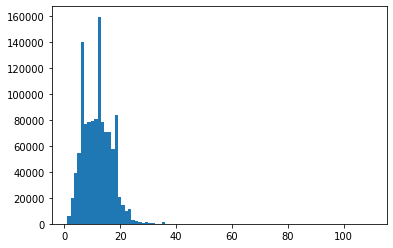

In [53]:
####### Padding and Truncating Sequences
lengths = [len(t.split(' ')) for t in train_data['content']]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [54]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [55]:
padded_train_sequences = get_sequences(tokenizer, train_data['content'])
padded_train_sequences[0]

array([   1,    1, 1388,    2,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

#### 4. Preparing the Labels

{'anger', 'anticipation', 'surprise', 'fear', 'trust', 'joy', 'disgust', 'sadness'}


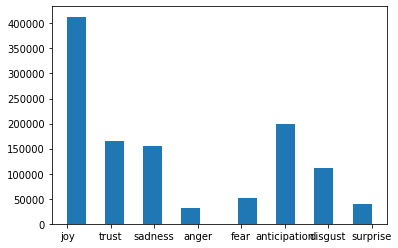

In [56]:
classes = set(train_data['emotion'])
print(classes)

plt.hist(train_data['emotion'], bins=16)
plt.show()

In [57]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [58]:
print(classes_to_index)
print(index_to_classes)

{'anger': 0, 'anticipation': 1, 'surprise': 2, 'fear': 3, 'trust': 4, 'joy': 5, 'disgust': 6, 'sadness': 7}
{0: 'anger', 1: 'anticipation', 2: 'surprise', 3: 'fear', 4: 'trust', 5: 'joy', 6: 'disgust', 7: 'sadness'}


In [59]:
labels = train_data['emotion']

names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

train_labels = names_to_ids(labels)
print(train_labels[0])

5


#### 5. Model

In [60]:
####### Creating the Model

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(25000, 128, input_length=50), #16 128   #50 300
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), #20 64
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 128)           3200000   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
Total params: 3,398,664
Trainable params: 3,398,664
Non-trainable params: 0
_________________________________________________________________


In [61]:
###### Training the Model
val_tweets = val_data['content']
val_labels = val_data['emotion']
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

val_tweets[0], val_labels[0]

('issa stalking tasha 😂 😂 😂 <lh>', 3)

In [62]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/3
36390/36390 [==============================] - 29956s 823ms/step - loss: 1.1881 - accuracy: 0.5684 - val_loss: 1.1267 - val_accuracy: 0.5907
Epoch 2/3
36390/36390 [==============================] - 4713s 130ms/step - loss: 1.0679 - accuracy: 0.6125 - val_loss: 1.1027 - val_accuracy: 0.5998
Epoch 3/3
36390/36390 [==============================] - 5028s 138ms/step - loss: 1.0044 - accuracy: 0.6363 - val_loss: 1.1102 - val_accuracy: 0.5981


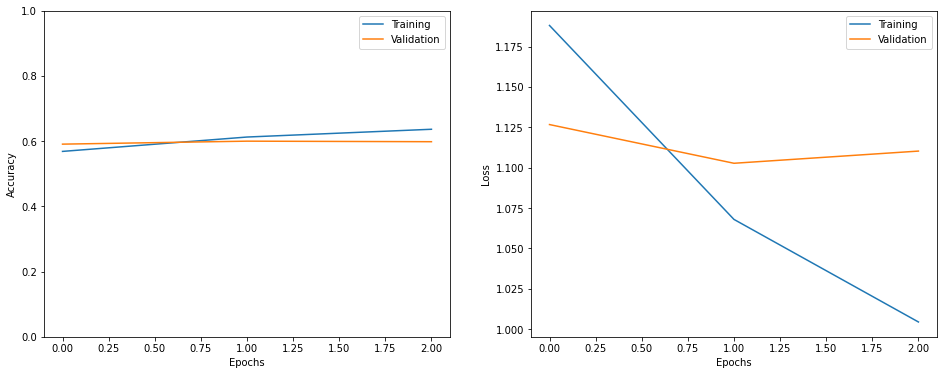

In [63]:
##### evaluation
show_history(h)

In [64]:
####### predicting test data on the model

test_tweets = test_df['content']
test_sequences = get_sequences(tokenizer, test_tweets)

pred_result = model.predict_classes(test_sequences)

ids_to_names = lambda pred_result: np.array([index_to_classes.get(x) for x in pred_result])
pred_labels = ids_to_names(pred_result)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [65]:
# save the result
test_df['emotion']=pred_labels
test_df.drop(columns=['hashtags','text','content'],inplace=True)
test_df.index.rename('id',inplace=True)
test_df.columns=['emotion']
test_df.to_csv('submitLSTM_25k_TT_DiffmodelParamEP3.csv')  # LSTMNeuralNetwork_25k_EP3.csv

## Result Evaluation

The prediction result accuracy in this competition is obtained by submitting the prediction csv on kaggle where the predicted results are evaluated. For this competition I submitted around 17 attempts, and would like to share best results of each model.

So far, LSTM model gives better accuracy. In order to improve the accuracy, the model needs to be improved. The Naive Bayes model and Logistic Regression are worth tyring because of their simplistic nature and also they give fast results. 

### Naive Bayes

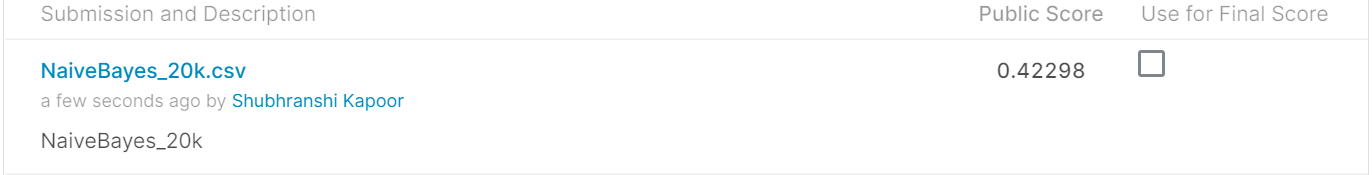

### Logistic Regression

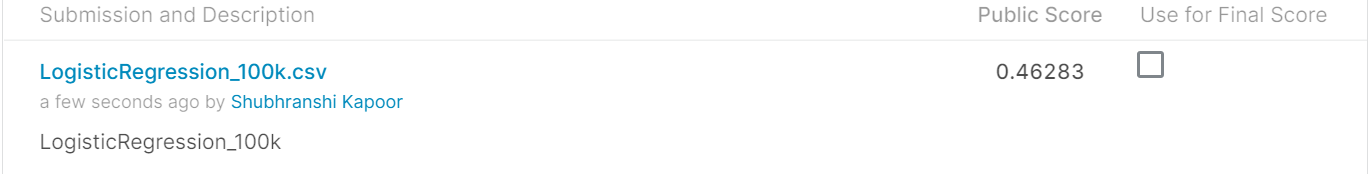

### LSTM Neural Network

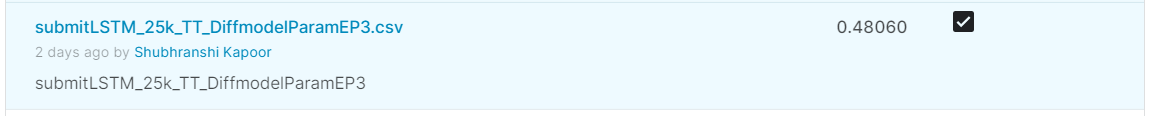

## Conclusion

##### In conclusion, below are the observations that i learnt from this project so far.


1. Decision Tree Model and SVM take a huge amount of time to train. Given the large size of the data, these models take a lot of time and give average results.


2. As compared to other models, Naive Bayes and LogisticRegression are quite fast and give decent result given the size of data and simplicity of these model. They can be considered as baseline models for tweet emotion recognition. The performance of these models depends highly on the number of features(tokens) considered in the training phase. Taking more features will increase the performance, however after certain amount, the increase in performance does not vary much with the size. The real challenge is to find the appropriate number of features.


3. Lemmatization is the process of reducing inflected words to their dictionary form. Text preprocessing approaches like lemmatization and removing stop words can be very helpful to obtain meaningful words from our tweet data.


4. LSTM neural network gives better performance in comparision to other models. However, tuning the paramenter and layers requires more work. Also, the model tends to overfit if we increase the number of epochs. Performance of the model improves if number of features are increased. However we can say that the models performs poorly if we increase the features too much. Thus, we need to find suitable combination of number of features(tokens) and epoch to give better accuracy and avoid overfitting. 


##### For future progress, I will try to implement BERT to obtain more meaningful tokens where the semantic relation is also maintained and use these tokens to train the LSTM model. LSTM model can also be enchanced by adding more layers and fine tuning the parameters.